In [1]:
!pip install transformers==4.3.3 --quiet

In [2]:
import os
from collections import defaultdict
from textwrap import wrap

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# importing augmented receiver operation curves to check how each class perform prediction for the labels
# import pytorch_lightning as pl
# from pytorch_lightning.metrics.functional.classification import auroc

In [3]:
assert os.environ['COLAB_TPU_ADDR']

In [4]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl --quiet

In [5]:
# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm

# Creates a random tensor on xla:1 (a Cloud TPU core)
dev = xm.xla_device()
# Creating a tensor on the second Cloud TPU core
# second_dev = xm.xla_device(n=2, devkind='TPU')
# t2 = torch.zeros(3, 3, device = second_dev)
# print(t2)

In [6]:
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 21
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8

In [7]:
project_path = '/content/drive/MyDrive/dataset/'
train_data_path = os.path.join(project_path, 'traindata_clean.csv')

df = pd.read_csv(train_data_path, encoding='latin')

df.head()

,tweet,target
0,is upset that he can't update his facebook by ...,0
1,entity i dived many times for the ball. manage...,0
2,my whole body feels itchy and like its on fire,0
3,"entity no, it's not behaving at all. i'm mad. ...",0
4,entity not the whole crew,0


In [8]:
PRETRAINED_MODEL_NAME = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [9]:
# Finding the maximum token length

from tqdm import tqdm

token_lens = []

for t in tqdm(df.tweet):
    tokens = tokenizer.encode(t, max_length=512)
    token_lens.append(len(tokens))

100%|██████████| 1529862/1529862 [12:15<00:00, 2079.58it/s]


In [10]:
import pickle

with open(os.path.join(project_path, 'token_lens.txt'), 'wb') as file:
    pickle.dump(token_lens, file)

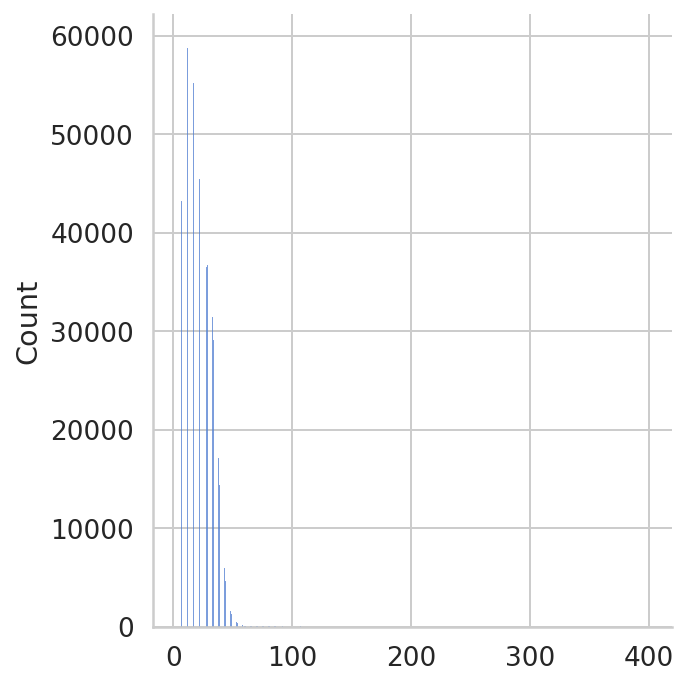

In [11]:
# Plot

ax = sns.displot(token_lens)
plt.savefig(os.path.join(project_path, 'token_lens.jpg'))

In [12]:
print(max(token_lens))
MAX_LEN=400

399


In [13]:
class TweetSentimentDataset(Dataset):
    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        tweet = self.tweets[item]
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'tweet': tweet,
            'targets': torch.tensor(target, dtype=torch.long),
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [14]:
# Creating training testing and validation data

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_test.shape, df_val.shape

((1376875, 2), (76494, 2), (76493, 2))

In [15]:
# Defining dataloader

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetSentimentDataset(
        tweets=df.tweet.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4,
    )

In [16]:
# Creating train, val and test dataloader

BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [17]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet', 'targets', 'input_ids', 'attention_mask'])

In [18]:
# BERT Model

bert_model = BertModel.from_pretrained(PRETRAINED_MODEL_NAME)

In [19]:
# Creating Sentiment classifier class

class TweetSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(TweetSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRETRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        o = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooler_output = o['pooler_output']
        output = self.drop(pooler_output)
        return self.out(output)

In [20]:
# Creating a model instance
CLASS_NAMES = ['negative', 'positive']

model = TweetSentimentClassifier(len(CLASS_NAMES))
model = model.to(dev)

input_ids = data['input_ids'].to(dev)
attention_mask = data['attention_mask'].to(dev)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 400])
torch.Size([16, 400])


In [21]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.6302, 0.3698],
        [0.6520, 0.3480],
        [0.8138, 0.1862],
        [0.5560, 0.4440],
        [0.5566, 0.4434],
        [0.6597, 0.3403],
        [0.6163, 0.3837],
        [0.5279, 0.4721],
        [0.5213, 0.4787],
        [0.7272, 0.2728],
        [0.6972, 0.3028],
        [0.5058, 0.4942],
        [0.6557, 0.3443],
        [0.6647, 0.3353],
        [0.5570, 0.4430],
        [0.7137, 0.2863]], device='xla:1', grad_fn=<SoftmaxBackward>)

In [22]:
# Defining epochs, optimizer, scheduler, loss_fn

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(dev)

In [23]:
# Training model function

def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(dev)
        attention_mask = d['attention_mask'].to(dev)
        targets = d['targets'].to(dev)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
# Evaluating model function

def eval_model(
    model,
    data_loader,
    loss_fn,
    device,
    n_examples
):
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(dev)
            attention_mask = d['attention_mask'].to(dev)
            targets = d['targets'].to(dev)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    dev, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    dev, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
